# Tutorial: First Guess

#### June 2023

In [1]:
cd /home

In [8]:
import matplotlib.pyplot as plt
import os 

from core.engine import preprocess, first_guess, get_metrics

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The first step is to preprocess the data, which involves normalizing the PSF, cropping windows centered on candidate companions, and obtaining the initial parameters from the VIP library. In order to accomplish this, we employ the `preprocess()` function as follows:

In [4]:
%%time
table, cube, psf = preprocess('./data/real/f_dhtau/')

CPU times: user 771 ms, sys: 1.29 s, total: 2.06 s
Wall time: 1.92 s


The following files should be located within the dataset folder (`./data/real/f_dhtau` in this example), using exactly the same names:
- `centered_im.fits`: cube
- `median_unsat.fits`: psf
- `rotnth.fits`: rotation angles

If it is the first time we run the preprocess function, it will compute PCA+ADI using VIP and then store the preprocessed data to avoid preprocessing the dataset again.

We first filter our table to maintain only the coordinates we want to fit.

In [5]:
table = table[table['snr']>60.]
table

,x,y,flux,fwhm_mean,snr
0,384.839338,366.860187,278.385232,4.127939,68.267050
1,385.998693,727.507117,128.015363,4.261339,80.891019


Next, we will use the first_guess function to fit our parameters

In [6]:
%%time
first_guess(table, cube, psf, 
            window_size=30, 
            learning_rate=1e-2, 
            epochs=1e6,
            target_folder='./logs/f_dhtau',
            verbose=0)

[INFO] Training (x, y) = (384.84 366.86)


2023-07-05 07:39:58.832438: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-05 07:39:58.861233: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-05 07:39:58.898722: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

input shape:  (None, 80, 30, 30, 1)
[INFO] Training (x, y) = (386.00 727.51)
input shape:  (None, 80, 30, 30, 1)
CPU times: user 1min 13s, sys: 21.7 s, total: 1min 34s
Wall time: 1min 18s


,x,y,flux,fwhm_mean,snr,optimal_flux
0,384.839338,366.860187,278.385232,4.127939,68.267050,331.965973
1,385.998693,727.507117,128.015363,4.261339,80.891019,150.267212


## Visualizing results

In [35]:
model_path = './logs/f_dhtau/model_1'

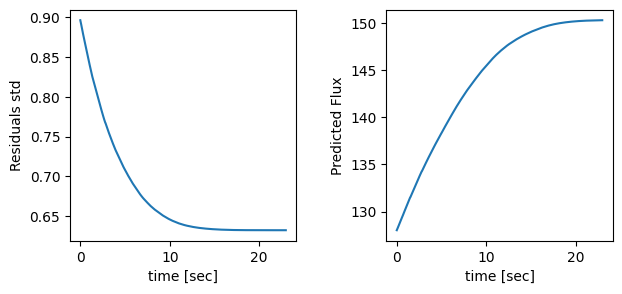

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(7, 3),
                         gridspec_kw={'hspace': 0, 'wspace': 0.4})

ylabels = ['Residuals std', 'Predicted Flux']
for i, metric in enumerate(['epoch_loss', 'epoch_flux']):
    train_metrics = get_metrics(f'{model_path}/logs/train/', show_keys=False, metric_name=metric)
    
    time = (train_metrics['wall_time'].values -train_metrics['wall_time'].values[0]) 
    axes[i].plot(time, train_metrics['value'].values)
    axes[i].set_xlabel('time [sec]')
    axes[i].set_ylabel(ylabels[i])


In [93]:
from core.engine import inference_step

In [106]:
fake_comp, real_comp, fluxes = inference_step(cube, psf, table.iloc[1]['x'], table.iloc[1]['y'], 
                          model_path=model_path, window_size=30)

input shape:  (None, 80, 30, 30, 1)
1/1 [==============================] - 0s 29ms/step


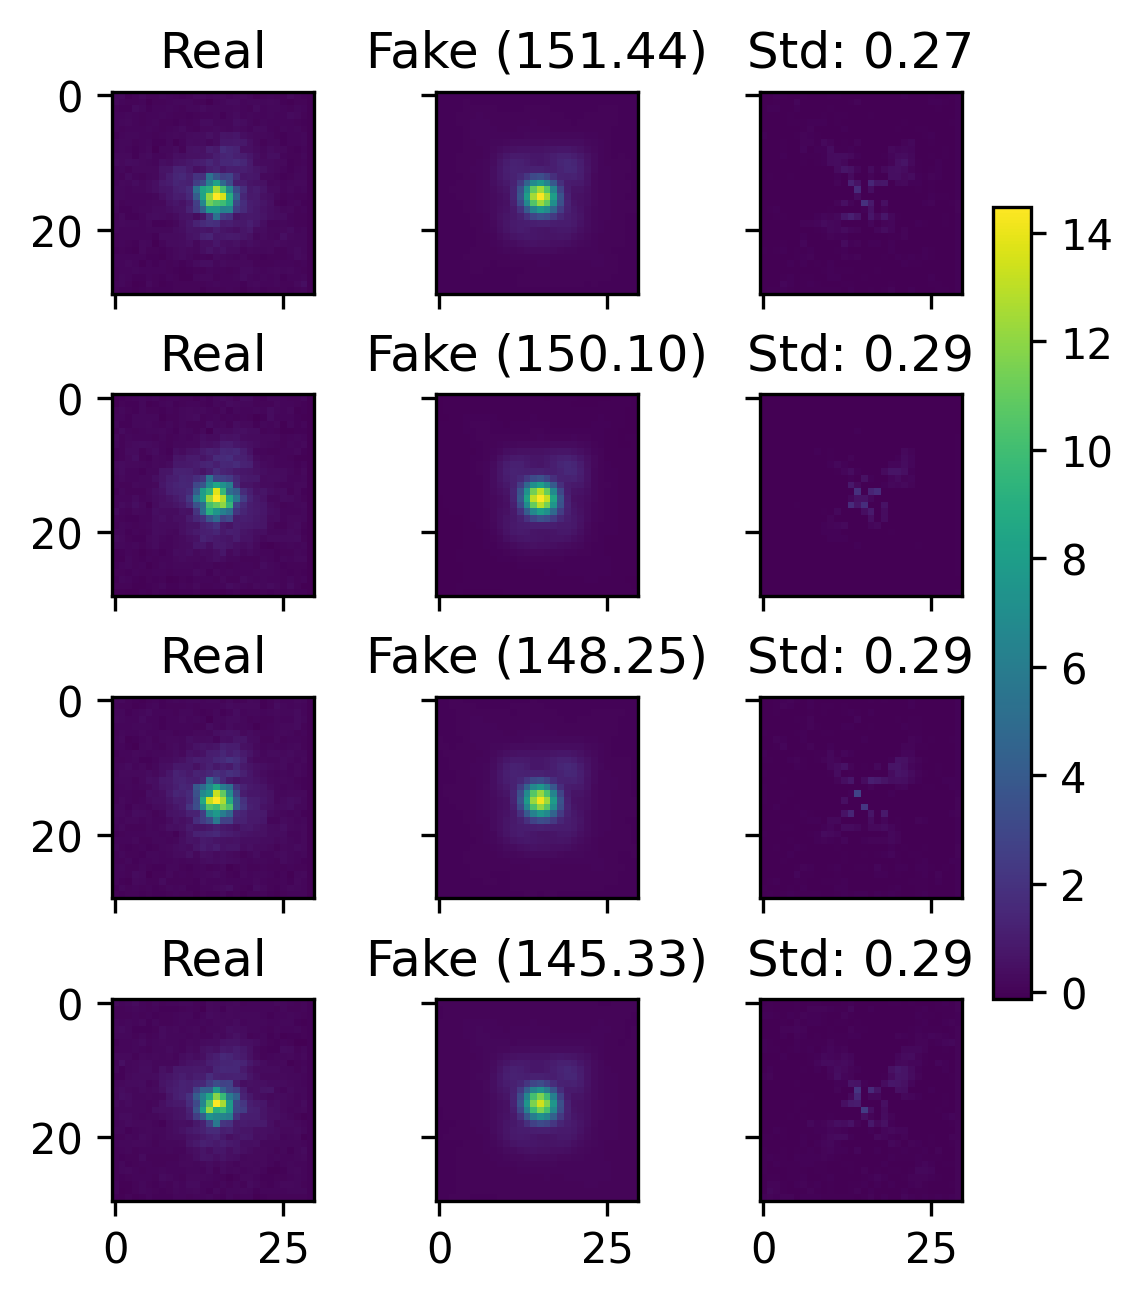

In [126]:
Ntotal = 4
fig, axes = plt.subplots(Ntotal, 3, dpi=300, sharex=True, sharey=True,
                        gridspec_kw={'hspace': 0.5, 'wspace': -0.5})

for N in range(Ntotal):
    
    axes[N][0].imshow(real_comp[N], vmin=real_comp[N].min(), vmax=real_comp[N].max())
    axes[N][0].set_title('Real')
    axes[N][1].imshow(fake_comp[N], vmin=real_comp[N].min(), vmax=real_comp[N].max())
    axes[N][1].set_title('Fake ({:.2f})'.format(fluxes[N]))
    im = axes[N][2].imshow(fake_comp[N] - real_comp[N], vmin=real_comp[N].min(), vmax=real_comp[N].max())

    axes[N][2].set_title('Std: {:.2f}'.format(np.std(fake_comp[N] - real_comp[N])))
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.70, 0.25, 0.02, 0.55])
fig.colorbar(im, cax=cbar_ax)
plt.show()